# Transfer Learning With TensorFlow - Part 1

## TensorFlow Hub (https://tfhub.dev/) is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

Transfer learning often allows you to get great results with less data.


In [ ]:
## Download the data


# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2023-12-28 13:04:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   154MB/s    in 1.0s    

2023-12-28 13:04:48 (154 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Creating data Loaders

# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

# Most common callbacks:
* Experiment tracking with TensorBoard (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)- save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* Early stopping (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
# Create TEnsorBoard Callback

import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers



# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# EfficientNetB0 feature vector (version 2)
efficientnet_v2_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [23]:
# Create model - ResNet_v2_50
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [24]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log file

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231228-132246
Epoch 1/5
24/24 [==============================] - 21s 616ms/step - loss: 1.9790 - accuracy: 0.3333 - val_loss: 1.1957 - val_accuracy: 0.6200
Epoch 2/5
24/24 [==============================] - 13s 547ms/step - loss: 0.9062 - accuracy: 0.7160 - val_loss: 0.8777 - val_accuracy: 0.7164
Epoch 3/5
24/24 [==============================] - 13s 574ms/step - loss: 0.6319 - accuracy: 0.8067 - val_loss: 0.7459 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 11s 482ms/step - loss: 0.4788 - accuracy: 0.8733 - val_loss: 0.7051 - val_accuracy: 0.7764
Epoch 5/5
24/24 [==============================] - 13s 558ms/step - loss: 0.3938 - accuracy: 0.9013 - val_loss: 0.6879 - val_accuracy: 0.7736


In [ ]:

import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

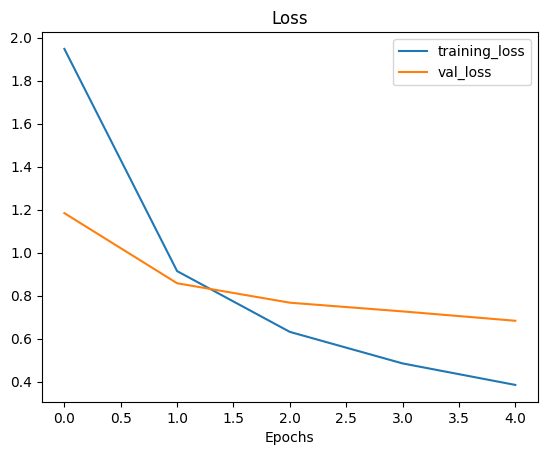

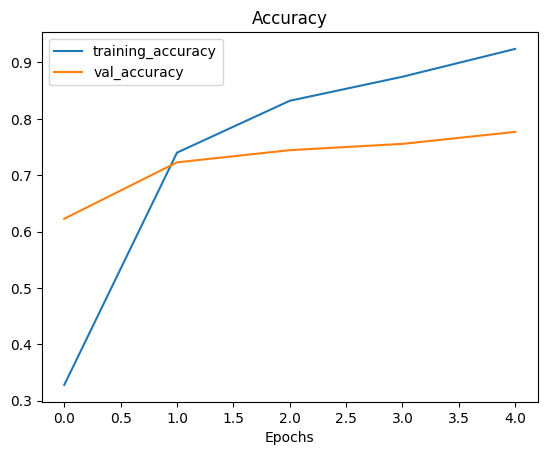

In [ ]:

plot_loss_curves(resnet_history)


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Create model - EfficienetNetB0
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])



Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20231228-130519
Epoch 1/5
24/24 [==============================] - 25s 547ms/step - loss: 1.8018 - accuracy: 0.4547 - val_loss: 1.2545 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 9s 397ms/step - loss: 1.0424 - accuracy: 0.7720 - val_loss: 0.8409 - val_accuracy: 0.8280
Epoch 3/5
24/24 [==============================] - 10s 428ms/step - loss: 0.7437 - accuracy: 0.8453 - val_loss: 0.6802 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 13s 538ms/step - loss: 0.6042 - accuracy: 0.8707 - val_loss: 0.5975 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 10s 438ms/step - loss: 0.5110 - accuracy: 0.8907 - val_loss: 0.5445 - val_accuracy: 0.8676


In [ ]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


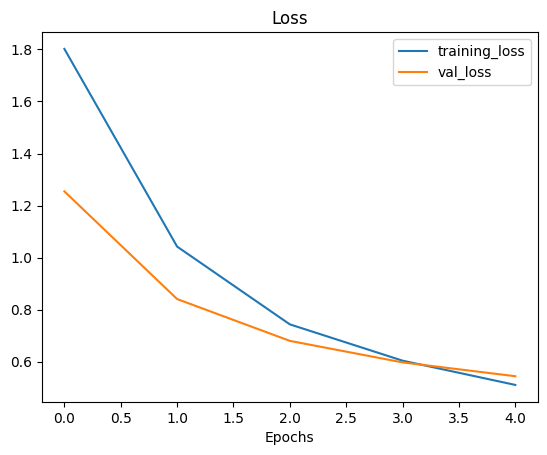

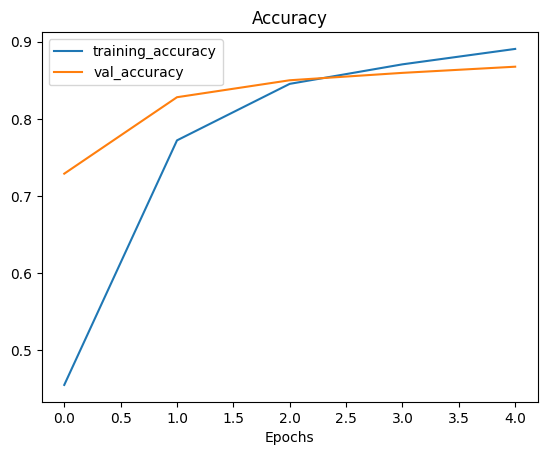

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
# Create model - Efficientnet_v2
efficientnet_v2_model = create_model(model_url=efficientnet_v2_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_v2_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_v2_history = efficientnet_v2_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnet_v2")])



Saving TensorBoard log files to: tensorflow_hub/efficientnet_v2/20231228-130718
Epoch 1/5
24/24 [==============================] - 21s 545ms/step - loss: 2.0380 - accuracy: 0.3147 - val_loss: 1.5657 - val_accuracy: 0.5884
Epoch 2/5
24/24 [==============================] - 10s 413ms/step - loss: 1.3733 - accuracy: 0.6333 - val_loss: 1.1615 - val_accuracy: 0.6960
Epoch 3/5
24/24 [==============================] - 9s 391ms/step - loss: 1.0507 - accuracy: 0.7373 - val_loss: 0.9732 - val_accuracy: 0.7276
Epoch 4/5
24/24 [==============================] - 10s 431ms/step - loss: 0.8783 - accuracy: 0.7867 - val_loss: 0.8730 - val_accuracy: 0.7496
Epoch 5/5
24/24 [==============================] - 10s 429ms/step - loss: 0.7637 - accuracy: 0.8160 - val_loss: 0.8144 - val_accuracy: 0.7616


In [ ]:
efficientnet_v2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


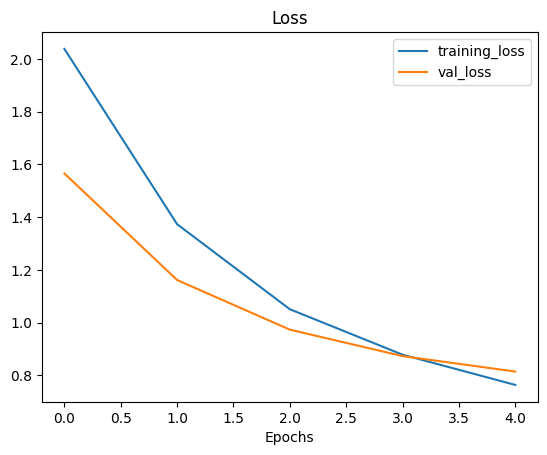

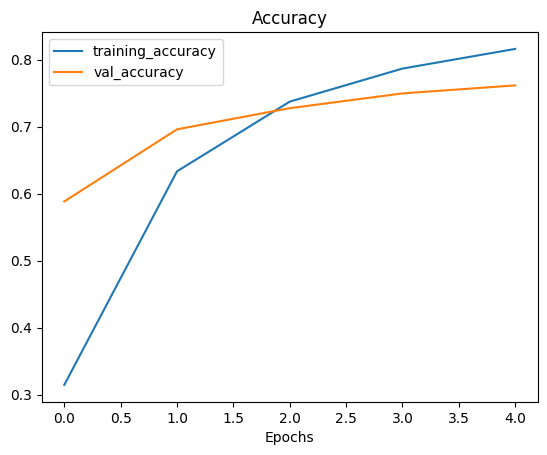

In [ ]:
plot_loss_curves(efficientnet_v2_history)

In [28]:
import pandas as pd

table_1 = pd.DataFrame(columns = ['Model', 'Loss', 'Loss Validation', 'Accuracy', 'Accuracy Validation'])
table_1.loc[0] = ['resnet', resnet_history.history['loss'][4], resnet_history.history['val_loss'][4], resnet_history.history['accuracy'][4], resnet_history.history['val_accuracy'][4]]
table_1.loc[1] = ['efficientnetB0', efficientnet_history.history['loss'][4], efficientnet_history.history['val_loss'][4], efficientnet_history.history['accuracy'][4], efficientnet_history.history['val_accuracy'][4]]
table_1.loc[2] = ['efficientnet_v2', efficientnet_v2_history.history['loss'][4], efficientnet_v2_history.history['val_loss'][4], efficientnet_v2_history.history['accuracy'][4], efficientnet_v2_history.history['val_accuracy'][4]]
table_1

,Model,Loss,Loss Validation,Accuracy,Accuracy Validation
0,resnet,0.393845,0.687918,0.901333,0.7736
1,efficientnetB0,0.511011,0.544470,0.890667,0.8676
2,efficientnet_v2,0.763686,0.814388,0.816000,0.7616


# EfficientnetB0 shows the best results.

# All three transfer learning models had far better results than the simple models (previous notebook 03) and using less images during training (only 10%).

On the 10 classes classification problem the best model using the following architecture:
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),

  Conv2D(10, 3, activation='relu'),
  
  MaxPool2D(),
  
  Conv2D(10, 3, activation='relu'),
  
  Conv2D(10, 3, activation='relu'),
  
  MaxPool2D(),
  
  Flatten(),
  
  Dense(10, activation='softmax')

Had poor metrics after 10epochs with data augmentation:

 loss: 1.8293 - accuracy: 0.3732 - val_loss: 1.6303 - val_accuracy: 0.4416